Group 1 Google Colab environment.

Upgrade our pip environment to ensure we have access to the latest pip packages on pypi.

In [ ]:
!python3 -m pip install --upgrade pip

Install dependencies

In [ ]:
!python3 -m pip install \
datasets \
implicit \
scikit-surprise \
pillow \
matplotlib \
tqdm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.8 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357276 sha256=4a00e3065b1cd7acf49cc8da0ac11c1c5b7f920a7b515739f19a77a9a1fa46b4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Import our required packages

In [1]:
import gzip
import random
import scipy
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import numpy as np

from collections import defaultdict
from datasets import load_dataset, Dataset as DS
from implicit import bpr
from implicit.evaluation import train_test_split as bpr_train_test_split
from implicit.evaluation import leave_k_out_split, precision_at_k, AUC_at_k, ndcg_at_k
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split

from matplotlib import pyplot as plt
from tqdm import tqdm

C:\Miniconda\envs\dsc210\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the Amazon reviews dataset from Huggingface

In [2]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Musical_Instruments", trust_remote_code=True)
print(dataset["full"][0])
dataset_items = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Musical_Instruments", trust_remote_code=True)
print(dataset_items["full"][0])

#Print our splits
print(dataset.keys())
print(len(dataset["full"]))
print(dataset_items.keys())
print(len(dataset_items["full"]))

Using the latest cached version of the module from C:\Users\Antariksha Ray\.cache\huggingface\modules\datasets_modules\datasets\McAuley-Lab--Amazon-Reviews-2023\16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Sun Nov 10 16:02:51 2024) since it couldn't be found locally at McAuley-Lab/Amazon-Reviews-2023, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Antariksha Ray\.cache\huggingface\modules\datasets_modules\datasets\McAuley-Lab--Amazon-Reviews-2023\16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Sun Nov 10 16:02:51 2024) since it couldn't be found locally at McAuley-Lab/Amazon-Reviews-2023, or remotely on the Hugging Face Hub.


{'rating': 5.0, 'title': 'Five Stars', 'text': 'Great headphones, comfortable and sound is good. No complaints. I would buy again.', 'images': [], 'asin': 'B003LPTAYI', 'parent_asin': 'B003LPTAYI', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650586000, 'helpful_vote': 0, 'verified_purchase': True}
{'main_category': 'Musical Instruments', 'title': 'Pearl Export Lacquer EXL725S/C249 5-Piece New Fusion Drum Set with Hardware, Honey Amber', 'average_rating': 4.2, 'rating_number': 22, 'features': ['Item may ship in more than one box and may arrive separately', '(22x18, 10x7, 12x8, 16x16, 14x5.5)', 'P930 Demonator Pedal', '830 Hardware Pack', 'Matching snare, REMO snare batter side head'], 'description': ["Introducing the best selling drum set of all time... Export Series returns and this time with a lacquer finish. EXL Export Lacquer Series incorporates Pearl's S.S.T. Superior Shell Technology, Opti-Loc tom mounts, all-new 830 Series Hardware with a P-930 Pedal, and a choice

Load the dataset into a pandas dataframe

In [31]:
random_state = 33
df = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=0.5, random_state=random_state)

print(df.head())

print(df.dtypes)
reader = Reader(rating_scale=(1, 5))

surprise_data = Dataset.load_from_df(df[['user_id', 'parent_asin', 'rating']], reader)


        rating                   title  \
36861      5.0              Five Stars   
36728      4.0          My first baton   
142396     5.0             Works Great   
83052      3.0  Good sound with issues   
218173     5.0     Quality made cable.   

                                                     text images        asin  \
36861                           Favorite headphones ever!     []  B003LPTAYI   
36728   Nicely made, pleasant balance. I haven't seen ...     []  B000EEJIV4   
142396  Works fine with older Casio WK-1200.  More erg...     []  B019SKINGA   
83052   I had pops, modulation and a white noise issue...     []  B01AUSB4ZQ   
218173                                       Works great.     []  B07RGP5WYL   

       parent_asin                       user_id      timestamp  helpful_vote  \
36861   B003LPTAYI  AHEW4RN4A7C5DZKQ3V3C5WIIDHJQ  1489184381000             0   
36728   B000EEJIV4  AG43EYXSK76E5O6KIOH7EYC2KASA  1366828748000             0   
142396  B019SKINGA  AE2

In [32]:
len(df)

150872

In [33]:
df_items = pd.DataFrame(dataset_items['full'])

In [34]:
# userIDs is a map from user_id to index
# itemIDS is a map from item_id to index
# indexToUser is a map from the index to the user ID
# indexToItem is a map from the index to the item ID
# asinToParentAsin is a map from asin to parent asin (item ID of all variants)
userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    if user_id not in userIDs:
        userIDs[user_id] = len(userIDs)
        indexToUser[userIDs[user_id]] = user_id
    if item_id not in itemIDs:
        itemIDs[item_id] = len(itemIDs)
        indexToItem[itemIDs[item_id]] = item_id
        asinToParentAsin[item_id] = parent_item_id
    if parent_item_id not in parentIDs:
        parentIDs[parent_item_id] = len(parentIDs)
        indexToParent[parentIDs[parent_item_id]] = parent_item_id


nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
print(f"There are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")


150872it [00:10, 14069.82it/s]

There are a total of 80440 users and 47852 products with a total of 56798 items including all variants.


# SVD

In [35]:
k = 5 # number of latent factors
svd = SVD(n_factors = k, verbose=True)
trainset, testset = train_test_split(surprise_data, test_size=.25, random_state=random_state)

svd.fit(trainset)
predictions = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [36]:
accuracy.rmse(predictions, verbose=True) # root mean squared error

RMSE: 1.1280


1.1280217455468797

In [37]:
# A sample Prediction contains the user id (uid), item id(iid), actual rating (r_ui), estimated rating (est), and additional details (details).
(predictions[0])

Prediction(uid='AHFFCP63UNK2HZOQJFJHVWAONKFQ', iid='B0B8M5FJ9W', r_ui=5.0, est=4.60376595498465, details={'was_impossible': False})

In [38]:
def get_top_n(predictions, n=3):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=3)


In [39]:
# Print the recommended items for the first user
uid0, iids = None, None
for uid, user_ratings in top_n.items():
    uid0 = uid
    iids = [iid for (iid, _) in user_ratings]
print(f"User id that we inspect: {uid0}")

User id that we inspect: AHQDYKP77D5ZFKU5TYD3TZWFLNTA


In [40]:
# Check the similarity between a user and their items latent factors

user_ids = trainset.all_users()  # This returns a list of all user ids
inner_user_id = random.choice(user_ids)
user_vector = svd.pu[inner_user_id]
raw_user_id = trainset.to_raw_uid(inner_user_id)

# Get the list of items (item_ids) from the trainset
item_ids = trainset.all_items()

preds = []
# Predict ratings for a specific user for all items
for item_id in item_ids:
    raw_item_id = trainset.to_raw_iid(item_id)
    preds.append(svd.predict(raw_user_id, raw_item_id))

# Extract the item IDs that have the highest predicted ratings
predicted_items = sorted(preds, key=lambda x: x.est, reverse=True)
# print(predicted_items[:5])

# Get the item IDs sorted by the predicted rating
for pred in predicted_items[:3]:
    inner_item_id = trainset.to_inner_iid(pred.iid)
    item_vector = svd.qi[inner_item_id]
    print(np.dot(user_vector, item_vector))



0.012461711233188323
0.013367807444007541
5.986566585595467e-05


In [41]:
# Check what the user has reviewed
user0_reviews = DS.from_pandas(df).filter(lambda row: row["user_id"] == uid0)

Filter: 100%|██████████| 150872/150872 [00:03<00:00, 40778.19 examples/s]


In [42]:
user0_reviewed_items = user0_reviews["parent_asin"]
user0_reviewd_items_images = dataset_items.filter(lambda row: row["parent_asin"] in user0_reviewed_items)

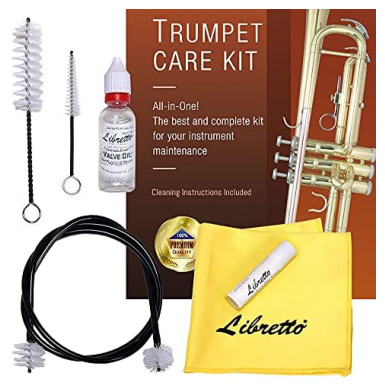

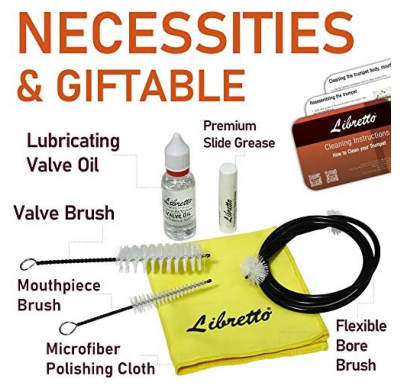

In [45]:
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["full"]["images"]:
        for large_image in img["large"][:2]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

show_images(user0_reviewd_items_images)


In [46]:
# Check what the model recommends for the user
uid0_images = []
filtered_dataset = dataset_items.filter(lambda row: row["parent_asin"] in iids)

filtered_dataset["full"].to_pandas().head()
    

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Sports & Outdoors,Libretto Trumpet (Cornet) ALL-INCLUSIVE Care K...,4.7,2455,[All-Inclusive Kit - Everything you need for i...,[],17.95,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Trumpet care kit', 'Libretto Trump...",Libretto,"[Musical Instruments, Instrument Accessories, ...","{""Item Package Dimensions L x W x H"": ""5.98 x ...",B07DR9Z128,None,None,None


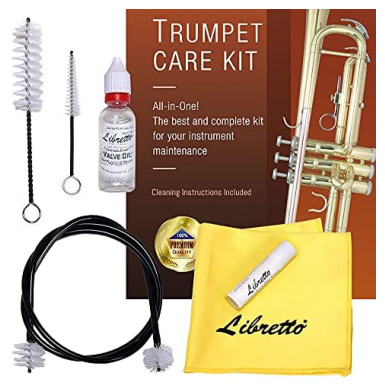

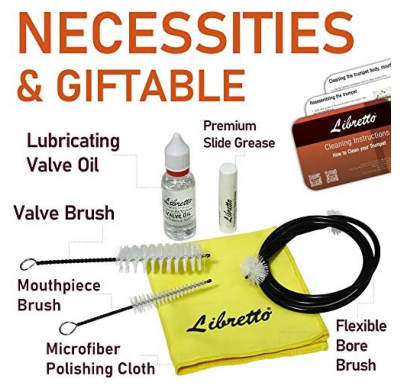

In [47]:
show_images(filtered_dataset)

### Recommendations for items and accessories that match with user's previous choices. Also, we have approximated the huge matrix with latent factors of much lower dimension!

In [48]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [49]:
precisions, recalls = precision_recall_at_k(predictions, k=3, threshold=4)

# Take the average over all values
precision = np.mean(np.array([prec for prec in precisions.values()]))
recall = np.mean(np.array([rec for rec in recalls.values()]))

print(f"Precision={precision}, recall={recall}, f1={(2*precision*recall)/(precision+recall)}")

Precision=0.7818384953637318, recall=0.7822492537893242, f1=0.7820438206401411


# Bayesian Personalized Ranking

In [50]:
# df_bpr = pd.DataFrame(dataset['full'])
df_bpr = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=.5, random_state=random_state)
# df_bpr = pd.DataFrame(dataset['full'][:len(dataset['full']) // 2])

random_state = 33


In [51]:
df = df_bpr
# userIDs is a map from user_id to index
# itemIDS is a map from item_id to index
# indexToUser is a map from the index to the user ID
# indexToItem is a map from the index to the item ID
# asinToParentAsin is a map from asin to parent asin (item ID of all variants)
userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    if user_id not in userIDs:
        userIDs[user_id] = len(userIDs)
        indexToUser[userIDs[user_id]] = user_id
    if item_id not in itemIDs:
        itemIDs[item_id] = len(itemIDs)
        indexToItem[itemIDs[item_id]] = item_id
        asinToParentAsin[item_id] = parent_item_id
    if parent_item_id not in parentIDs:
        parentIDs[parent_item_id] = len(parentIDs)
        indexToParent[parentIDs[parent_item_id]] = parent_item_id


nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
print(f"There are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")


150872it [00:10, 14166.03it/s]

There are a total of 80440 users and 47852 products with a total of 56798 items including all variants.


In [52]:
Xui = scipy.sparse.lil_matrix((nUsers, nParents)) # Initialized after extracting the number of users and items
for ifx, row in tqdm(df.iterrows()):
    user_id, item_id = row["user_id"], row["parent_asin"]
    Xui[userIDs[user_id], parentIDs[item_id]] = 1 # Only storing positive feedback instances
Xui_csr = scipy.sparse.csr_matrix(Xui)

150872it [00:10, 13899.42it/s]


In [53]:
Xui_csr

<80440x47852 sparse matrix of type '<class 'numpy.float64'>'
	with 150259 stored elements in Compressed Sparse Row format>

In [54]:
print(f"Sparsity of the matrix = {(1 - (Xui_csr.nnz/(Xui_csr.shape[0]*Xui_csr.shape[1]))):.6f}%")

Sparsity of the matrix = 0.999961%


In [55]:
(Xui_csr.nnz/(Xui_csr.shape[0]*Xui_csr.shape[1]))

3.9036272248848835e-05

In [56]:
# Xui_train, Xui_test = bpr_train_test_split(Xui_csr, train_percentage=0.75, random_state=random_state)
Xui_train, Xui_test = leave_k_out_split(Xui_csr, K=1, random_state=random_state)

In [57]:
k = 5 # latent factors
model = bpr.BayesianPersonalizedRanking(factors = k, random_state=random_state, iterations=100, regularization=0.01)
model.fit(Xui_train)

100%|██████████| 100/100 [00:00<00:00, 113.61it/s, train_auc=77.77%, skipped=0.13%]


In [58]:
bpr_precision = precision_at_k(model, Xui_train, Xui_train, 10, True)
bpr_auc = AUC_at_k(model, Xui_train, Xui_train, 10, True)
bpr_ndcg = ndcg_at_k(model, Xui_train, Xui_train, 10, True)

100%|██████████| 80440/80440 [00:18<00:00, 4286.41it/s]


In [59]:
print(f"Precision={bpr_precision}, AUC={bpr_auc}, NDCG={bpr_ndcg}")

Precision=0.0, AUC=0.4998955073991392, NDCG=0.0


In [60]:
bpr_precision = precision_at_k(model, Xui_train, Xui_test, 10, True)
bpr_auc = AUC_at_k(model, Xui_train, Xui_test, 10, True)
bpr_ndcg = ndcg_at_k(model, Xui_train, Xui_test, 10, True)


100%|██████████| 11749/11749 [00:02<00:00, 4340.85it/s]


In [61]:
print(f"Precision={bpr_precision}, AUC={bpr_auc}, NDCG={bpr_ndcg}")

Precision=0.005532385734956166, AUC=0.5026617872219713, NDCG=0.002637405544375163


In [62]:
itemFactors = model.item_factors
userFactors = model.user_factors

uid0index = userIDs[uid0]
recommended = model.recommend(uid0index, Xui_test[uid0index]) # Top k Recommendations for the user
related = model.similar_items(0) # Top 10 Highly similar to the first item (using cosine similarity)

print(recommended)
print(related)

(array([18290,  5365,  3526, 44036,  6614, 38202,  4855,  1141, 28765,
       39127]), array([0.2954206 , 0.26594418, 0.2643684 , 0.25499243, 0.25121957,
       0.25073633, 0.24146117, 0.24057591, 0.23592518, 0.23577929],
      dtype=float32))
(array([    0, 22250, 27428,  6649,  3114, 16778, 11554, 15323, 34341,
        1910]), array([1.        , 0.9767962 , 0.97630286, 0.9720609 , 0.97162217,
       0.9714114 , 0.9709005 , 0.9668142 , 0.96462727, 0.96425873],
      dtype=float32))


In [63]:
recommended[0]

array([18290,  5365,  3526, 44036,  6614, 38202,  4855,  1141, 28765,
       39127])

In [64]:
recommended_items = []
for recommendedId in recommended[0]:
    parent_asin = recommendedId
    row = df_items[df_items["parent_asin"] == parent_asin]
    recommended_items.append(row)

x = pd.concat(recommended_items, ignore_index=True)
print(len(x))
x

0


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author


In [65]:
# show the images of the recommended items
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["images"]:
        for large_image in img["large"][:2]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        
show_images(x)    

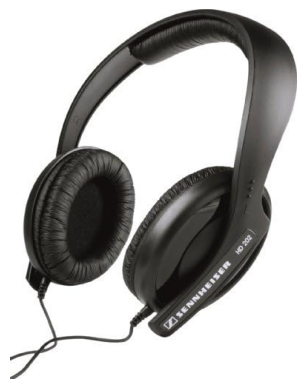

In [66]:
# What is the first item?
x = df_items[df_items["parent_asin"] == indexToParent[0]]
show_images(x)    

In [67]:
related_items = []
for relatedId in related[0]:
    parent_asin = asinToParentAsin[indexToItem[relatedId]]
    row = df_items[df_items["parent_asin"] == parent_asin]
    related_items.append(row)

x = pd.concat(related_items, ignore_index=True)
print(len(x))
x

10


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Home Audio & Theater,Sennheiser HD 202 II Professional Headphones (...,4.2,11767,"[Ideal for DJ's and audio pros,Total harmonic ...","[Product Description, The Sennheiser HD202II a...",None,"{'hi_res': [None], 'large': ['https://m.media-...",{'title': ['Here Is What You Are Paying For..'...,Sennheiser Consumer Audio,"[Musical Instruments, Pro & DJ Headphones]","{""Product Dimensions"": ""8 x 3 x 9.4 inches"", ""...",B003LPTAYI,None,None,None
1,Musical Instruments,The Original Hill Dark Rosin For Violin - Viol...,4.6,343,"[The ORIGINAL Hill Dark Rosin, not an imitatio...","[Hill Brand Dark Rosin, considered by many as ...",17.95,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Bernadel Rosin: Quality Rosin for ...,Hill,"[Musical Instruments, Instrument Accessories, ...","{""Item Weight"": ""0.04 Pounds"", ""Item model num...",B000F3FQP6,None,None,None
2,Musical Instruments,SoundChakra Rubber Ball Striker Mallet with Wo...,4.6,56,[✔ Brand new and high quality SoundChakra rubb...,[SoundChakra White Rubber Striker Mallet with ...,23.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",SoundChakra,"[Musical Instruments, Drums & Percussion, Hand...","{""Item Weight"": ""2.39 ounces"", ""Package Dimens...",B07564RMCR,None,None,None
3,All Electronics,Sound Town 8-inch 2-Way Portable PA Speaker wi...,3.6,301,[A class-D amplified portable speaker with rec...,[Sound Town 8-inch 2-Way Portable PA Speaker w...,None,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Ridgeway QS-805 Portable Audio Blu...,Sound Town,"[Musical Instruments, Live Sound & Stage, Moni...","{""Item Weight"": ""6.16 pounds"", ""Package Dimens...",B07H4G9P3Q,None,None,None
4,Musical Instruments,Hisonic HS120B Rechargeable & Portable PA (Pub...,4.4,1091,[Stand-alone portable PA (public address) syst...,[],127.98,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Pyle Wireless PA System: Is It Wor...,Hisonic,"[Musical Instruments, Live Sound & Stage, PA S...","{""Item Weight"": ""6 pounds"", ""Product Dimension...",B001H42HD6,None,None,None
5,Musical Instruments,"On-Stage Hot Wires Straight 1/4"" TRS Patch Cab...",4.6,780,"[Assorted vibrant colors, 17"" in length]",[Hot Wires PC1817TRS Balanced Patch Cables - R...,31.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['GLS Audio Patch Cable Cords 1/4"" t...",OnStage,"[Musical Instruments, Live Sound & Stage, Stag...","{""Brand"": ""OnStage"", ""Connector Type"": ""Straig...",B00M6SI0X8,None,None,None
6,Musical Instruments,Arturia MiniLab 3 Mini Hybrid Keyboard Controller,4.6,532,[GO WITH YOUR FLOW: MiniLab 3 is an easy keybo...,[],109.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",ARTURIA,"[Musical Instruments, Studio Recording Equipme...","{""Brand"": ""ARTURIA"", ""Connectivity Technology""...",B0BGMNKCNT,None,None,None
7,Musical Instruments,Getaria Wireless Guitar System 2.4GHz Digital ...,4.6,28,[Getaria GWS-6 Wireless guitar system supports...,[],None,"{'hi_res': [None, 'https://m.media-amazon.com/...",{'title': ['How to change channel and connect...,Getaria,"[Musical Instruments, Microphones & Accessorie...","{""Item Weight"": ""35 Grams"", ""Product Dimension...",B08PQB9W9Q,None,None,None
8,Musical Instruments,Vandoren SAXMIXA3 Alto Saxophone Mix Card Stre...,4.6,97,[Find your favorite reed without breaking the ...,[Vandoren has taken the guess work out of find...,24.2,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Vandoren SAXMIXA3 Alto Saxophone M...,Vandoren,"[Musical Instruments, Instrument Accessories, ...","{""Item Weight"": ""0.319 ounces"", ""Product Dimen...",B01DVF4OD4,None,None,None
9,Musical Instruments,M-Audio Nova | Large-Capsule Cardioid Condense...,4.3,34,"[1.1"" diameter evaporated gold 

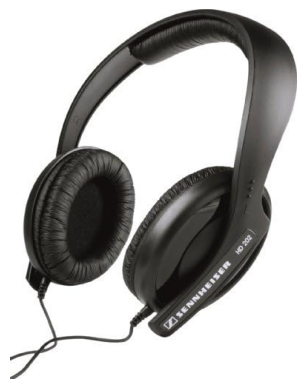

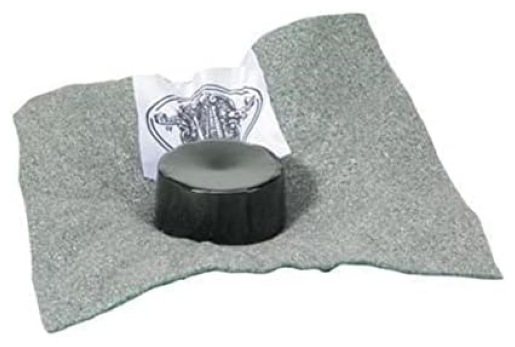

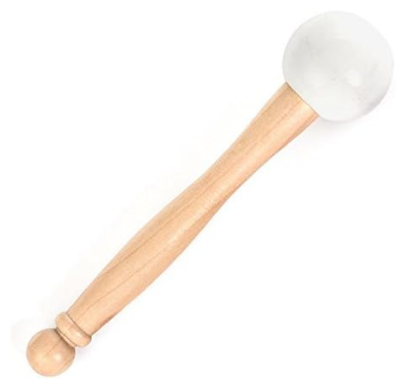

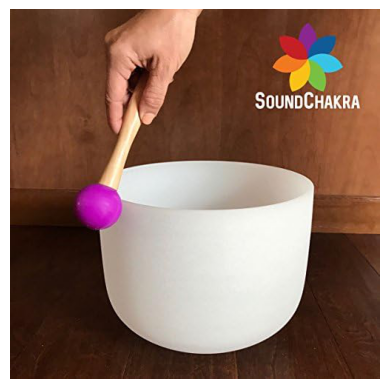

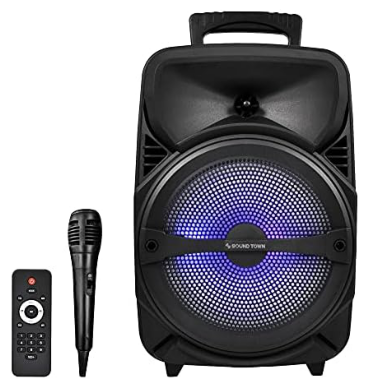

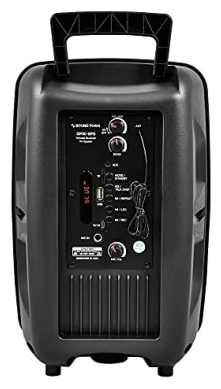

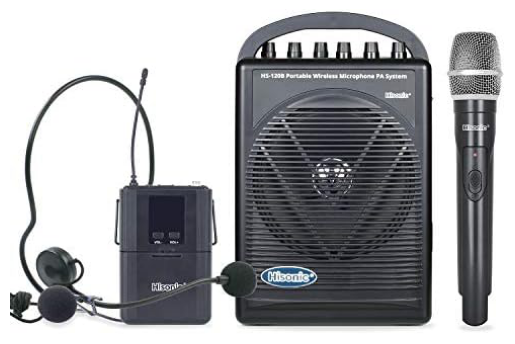

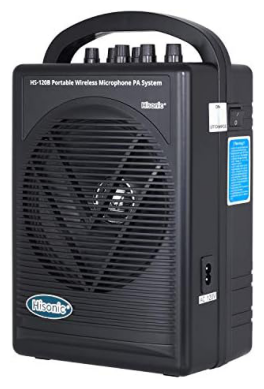

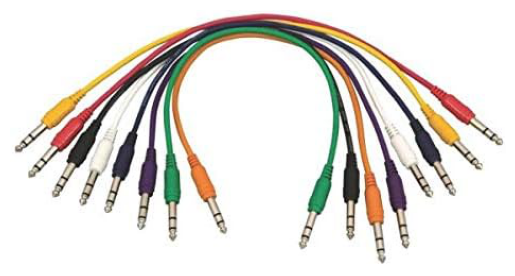

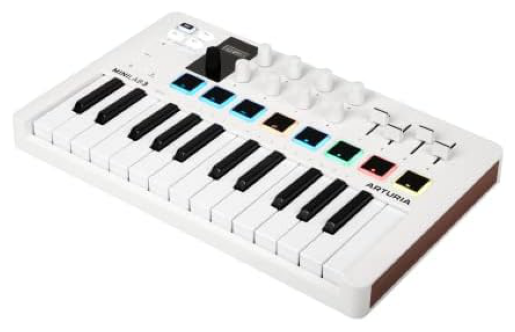

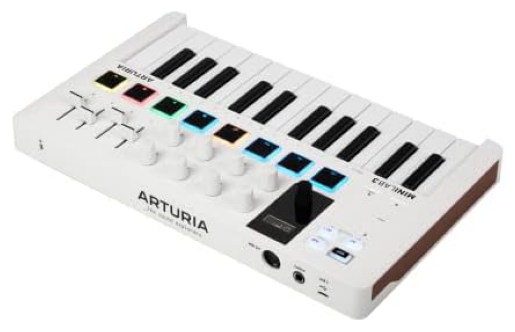

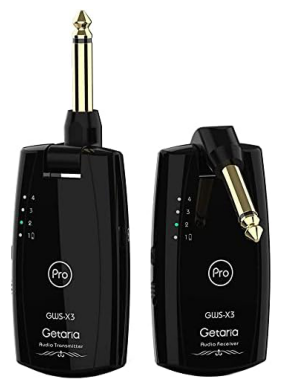

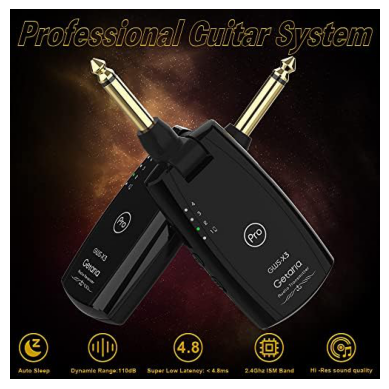

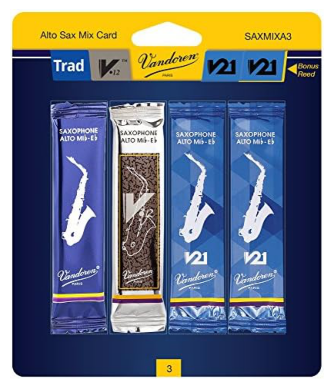

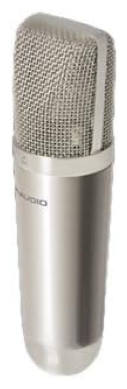

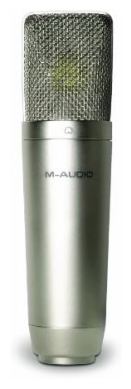

In [68]:
show_images(x)    

In [69]:
# Check the cosine similarity of the user and item latent factors for the first user
recommended = model.recommend(0, Xui_train[0])
for rec in recommended[0]:
    a = model.item_factors[rec]
    b = model.user_factors[0]
    print((a/np.linalg.norm(a))@(b/np.linalg.norm(b)))


0.30555564
0.2546579
0.48697892
0.20445168
0.33183163
0.5471013
0.25116616
0.4122908
0.5727334
0.46615997
